In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd()))
import pickle 
import numpy as np
import pandas as pd
from pyfrechet.metric_spaces import MetricData, Sphere

import matplotlib.pyplot as plt
import seaborn as sns

import geomstats.visualization as visualization

INFO: Using numpy backend


In [2]:
coverages=[]
alpha=0.05
M=Sphere(2)

for file in os.listdir(os.path.join(os.getcwd(), 'results')):
    infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
    result=pickle.load(infile)

    Dalpha=np.percentile(result['oob_errors'], (1-alpha)*100)
    coverages.append(np.mean(M.d(result['test_predictions'].data, 
                                 result['y_test_data']) <= Dalpha))

    infile.close()


In [3]:
print(coverages)
print(np.mean(coverages))

[0.9, 0.96, 0.98, 0.976, 0.9, 0.976, 0.9, 0.96, 0.98, 0.968, 0.96, 0.984, 0.94, 0.944, 0.96, 0.944, 0.96, 0.952, 0.92, 0.904]
0.9484


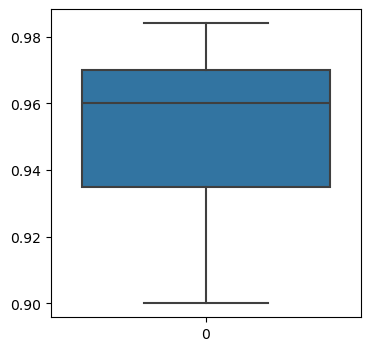

In [118]:
plt.figure(figsize=(4,4))
sns.boxplot(coverages)
plt.show()

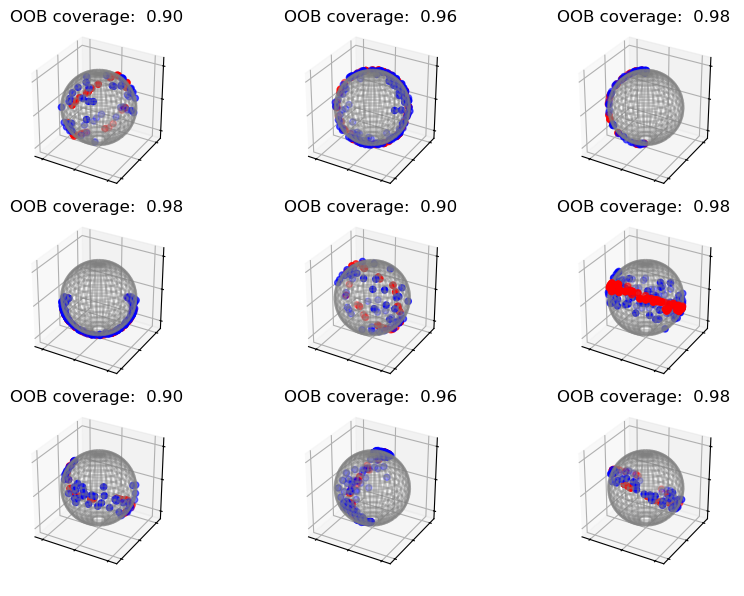

In [4]:
results=[]

for file in os.listdir(os.path.join(os.getcwd(), 'results')):
    infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
    result=pickle.load(infile)

    results.append(result)

    infile.close()

M=Sphere(2)
alpha=0.05
ncol=3
nrow=3

fig, axs =plt.subplots(nrow, ncol, subplot_kw={'projection': '3d'}, figsize=(10,7))
for i in range(nrow):
    for j in range(ncol):
        visualization.plot(results[ncol*i+j]['y_test_data'], space='S2', color='blue', ax=axs[i,j])
        visualization.plot(results[ncol*i+j]['test_predictions'], space='S2', color='red', ax=axs[i,j])
        axs[i,j].set_xlabel('')
        axs[i,j].set_ylabel('')
        axs[i,j].set_zlabel('')
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_zticklabels([])
        Dalpha=np.percentile(results[ncol*i+j]['oob_errors'], (1-alpha)*100)
        coverage=np.mean(M.d(results[ncol*i+j]['test_predictions'].data, 
                             results[ncol*i+j]['y_test_data']) <= Dalpha)
        axs[i,j].set_title(f'OOB coverage: {coverage: .2f}')    

# plt.tight_layout()
plt.show()

In [5]:
# For to create the grid for the sphere
def create_S2_grid(grid_size: int=200) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    u = np.linspace(0, 2 * np.pi, grid_size)
    v = np.linspace(0, np.pi, grid_size/2)
    x_grid = np.outer(np.cos(u), np.sin(v))
    y_grid = np.outer(np.sin(u), np.sin(v))
    z_grid = np.outer(np.ones(np.size(u)), np.cos(v))
    return (x_grid, y_grid, z_grid)

# Function to plot the prediction ball for given indices_to_plot list of indices
def plot_OOB_balls(grid: tuple[np.ndarray, np.ndarray, np.ndarray],
                   predictions: np.ndarray,
                   indices_to_plot: list[int],
                   Dalpha: float,
                   ax,
                   color='deepskyblue',
                   alpha=0.1) -> None:
    
    for index_to_plot in indices_to_plot:
        ax.scatter3D(predictions[index_to_plot,0],
                predictions[index_to_plot,1],
                predictions[index_to_plot,2], marker='x', color='red', s=30, alpha=1)
        
        for i in range(grid[2].shape[0]):
            for j in range(grid[2].shape[1]):
                if M.d(predictions[index_to_plot,:], np.array([grid[0][i,j], grid[1][i,j], grid[2][i,j]])) <= Dalpha:
                    ax.scatter3D(grid[0][i,j], grid[1][i,j], grid[2][i,j], color=color, alpha=alpha)    


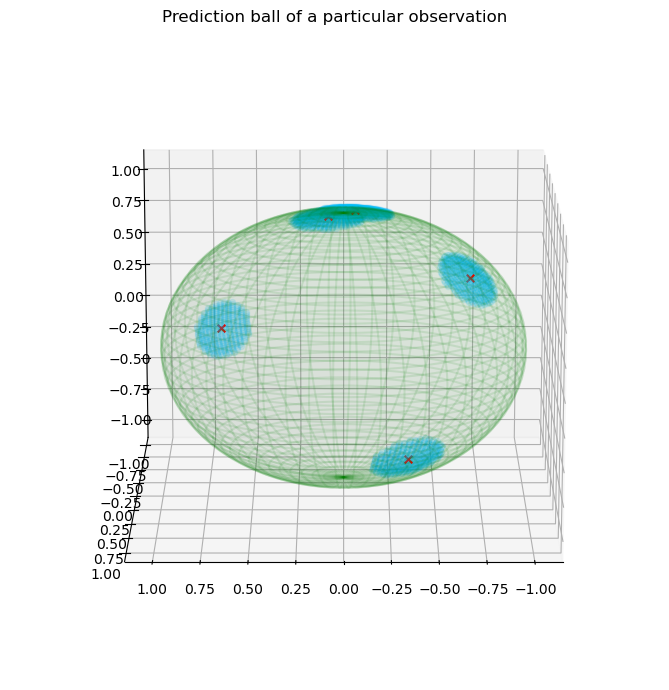

In [22]:
x_grid, y_grid, z_grid=create_S2_grid()

# Plot random forest predictions
fig=plt.figure(figsize=(12,7))
ax=plt.axes(projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)

# Plot OOB balls
plot_OOB_balls((x_grid, y_grid, z_grid), 
               predictions=results[17]['test_predictions'], 
               indices_to_plot=range(0,50,10), 
               Dalpha=np.percentile(results[17]['oob_errors'], (1-0.05)*100), 
               ax=ax)

ax.set_title('Prediction ball of a particular observation')
ax.view_init(elev=15, azim=90)
plt.tight_layout()
plt.show()

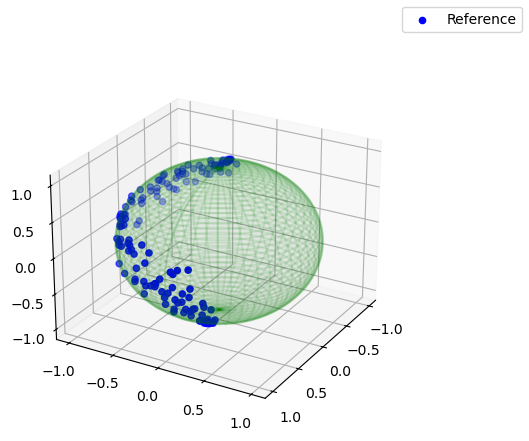

In [6]:
# For plotting the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_grid = np.outer(np.cos(u), np.sin(v))
y_grid = np.outer(np.sin(u), np.sin(v))
z_grid = np.outer(np.ones(np.size(u)), np.cos(v))

# Plot random forest predictions
#forest_predictions_cartesian = Hypersphere(dim=2).spherical_to_extrinsic(forest_predictions.data)
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(results[6]['y_train_data'][:,0],
            results[6]['y_train_data'][:,1],
            results[6]['y_train_data'][:,2], color='blue', label='Reference')
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.05)
ax.plot_wireframe(x_grid, y_grid, z_grid, color='green', alpha=0.1)
ax.view_init(elev=25, azim=30)
fig.legend()

plt.show()

In [7]:
sigmas=[0.1, 0.2, 0.25, 0.3]

def coverage_results(sigmas: list, sign_level: float=0.05) -> pd.DataFrame:
    
    coverage_df=pd.DataFrame(columns=['sample_index', 'sample_size', 'spiral', 'sigma', 'coverage', 'OOB_quantile'])

    for file in os.listdir(os.path.join(os.getcwd(), 'results')):
        infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
        result=pickle.load(infile)
        infile.close()

        Dalpha=np.percentile(result['oob_errors'], (1-sign_level)*100)
        coverage_df=pd.concat([coverage_df, 
                               pd.DataFrame({'sample_index': int(file.split('_')[1][4:]),
                                             'sample_size': int(file.split('_')[2][1:]),
                                             'spiral': file.split('_')[3][6:],
                                             'sigma': sigmas[int(file.split('_')[4][5:])-1],
                                             'coverage': np.mean(M.d(result['test_predictions'], result['y_test_data']) <= Dalpha),
                                             'OOB_quantile': Dalpha}, index=pd.RangeIndex(0,1))], 
                                ignore_index=True)
        
    coverage_df['sample_size']=coverage_df['sample_size'].astype('int')
    coverage_df['sample_index']=coverage_df['sample_index'].astype('int')
        
    return coverage_df

coverage_df=coverage_results(sigmas=sigmas, sign_level=0.05)
print(coverage_df.info())
coverage_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sample_index  20 non-null     int32  
 1   sample_size   20 non-null     int32  
 2   spiral        20 non-null     object 
 3   sigma         20 non-null     float64
 4   coverage      20 non-null     float64
 5   OOB_quantile  20 non-null     float64
dtypes: float64(3), int32(2), object(1)
memory usage: 928.0+ bytes
None


C:\Users\J2404\AppData\Local\Temp\ipykernel_4464\2208477924.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coverage_df=pd.concat([coverage_df,


,sample_index,sample_size,spiral,sigma,coverage,OOB_quantile
0,10,200,0,0.25,0.900,0.489008
1,10,500,0,0.25,0.960,0.549690
2,1,200,1,0.20,0.980,0.333119
3,1,500,1,0.20,0.976,0.297234
4,2,200,0,0.25,0.900,0.516914
5,2,500,0,0.25,0.976,0.508945
6,3,200,1,0.30,0.900,0.415821
7,3,500,1,0.30,0.960,0.478514
8,4,200,0,0.10,0.980,0.293488
9,4,500,0,0.10,0.968,0.214730


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_4464\1587047446.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(data=coverage_df, x='sample_size', y='coverage', hue='sample_size', palette=sns.color_palette())
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


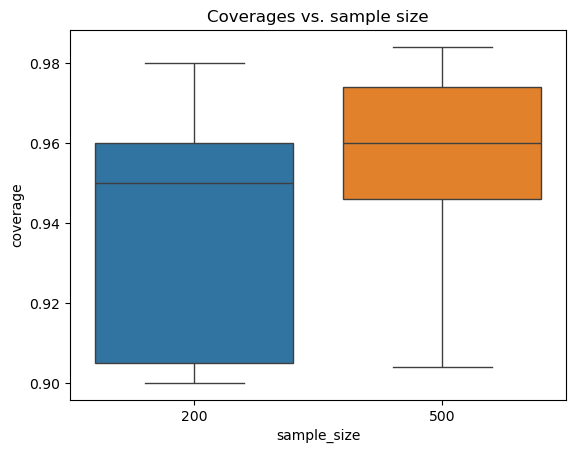

In [8]:
plt.figure()
sns.boxplot(data=coverage_df, x='sample_size', y='coverage', hue='sample_size', palette=sns.color_palette())
plt.legend().remove()
plt.title('Coverages vs. sample size')
plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_4464\1919128927.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(data=coverage_df[coverage_df.spiral=='0'], x='sample_size', y='coverage',
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_4464\1919128927.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  

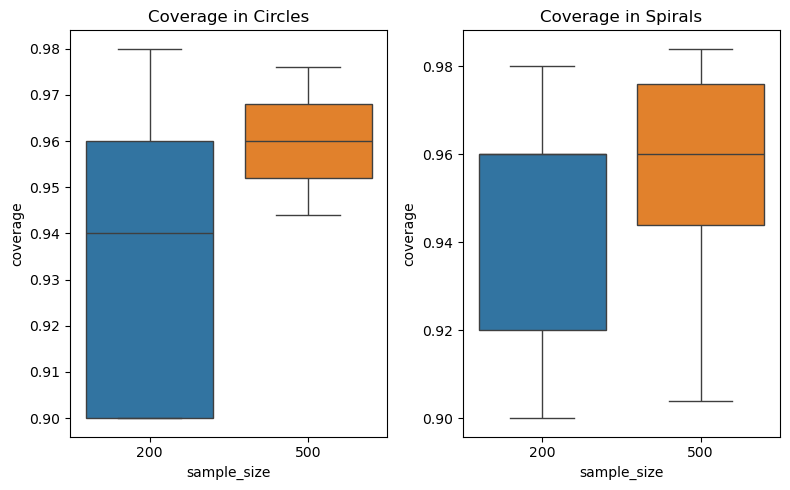

In [9]:
fig, axs=plt.subplots(1,2, figsize=(8,5))
sns.boxplot(data=coverage_df[coverage_df.spiral=='0'], x='sample_size', y='coverage', 
            hue='sample_size', palette=sns.color_palette(), ax=axs[0])
axs[0].set_title('Coverage in Circles')
axs[0].legend().remove()
sns.boxplot(data=coverage_df[coverage_df.spiral=='1'], x='sample_size', y='coverage', 
            hue='sample_size', palette=sns.color_palette(), ax=axs[1])
axs[1].set_title('Coverage in Spirals')
axs[1].legend().remove()

plt.tight_layout()
plt.show()

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\J2404\AppData\Local\Temp\ipykernel_4464\3168262734.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(data=coverage_df, x='sigma', y='coverage', hue='sample_size', palette=sns.color_palette())
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


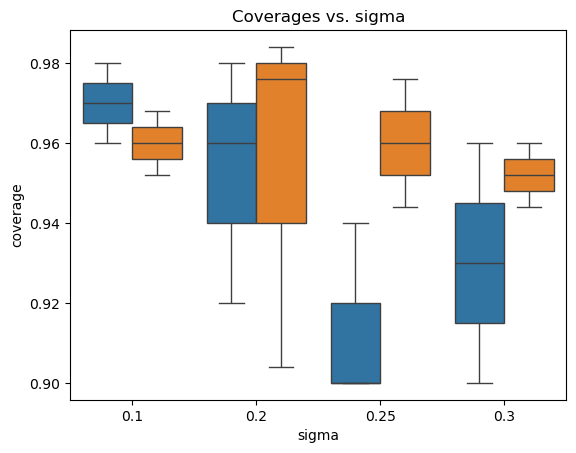

In [10]:
plt.figure()
sns.boxplot(data=coverage_df, x='sigma', y='coverage', hue='sample_size', palette=sns.color_palette())
plt.title('Coverages vs. sigma')
plt.legend().remove()
plt.show()